# Ultimate Take Home Challenge

## Part One: Exploratory Data Analysis

> The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [65]:
#Import Packages
import pandas as pd
import numpy as np
import time
import calendar
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

import shap
shap.initjs()

sns.set(style="whitegrid", font_scale=2)

pd.set_option('mode.chained_assignment', None)

#### i. Import logins.json

In [3]:
df = pd.read_json('logins.json')

#Visual check
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


The date appears to be incorrect: This should be 2014, not 1970.

In [4]:
#Change year to 2014
df['login_time'] = df['login_time'].apply(lambda dt: dt.replace(year=2014))

df.head()

,login_time
0,2014-01-01 20:13:18
1,2014-01-01 20:16:10
2,2014-01-01 20:16:37
3,2014-01-01 20:16:36
4,2014-01-01 20:26:21


In [5]:
df.dtypes

login_time    datetime64[ns]
dtype: object

In [6]:
df.isnull().sum()

login_time    0
dtype: int64

In [7]:
df.login_time.min()

Timestamp('2014-01-01 20:12:16')

In [8]:
df.login_time.max()

Timestamp('2014-04-13 18:57:38')

The login times range from 2014-01-01 20:12:16 to 2014-04-13 18:57:38.

#### ii. Aggregate Login Counts: 15 Minute Intervals

In [9]:
#Create count column
df['count'] = 1

df.head()

,login_time,count
0,2014-01-01 20:13:18,1
1,2014-01-01 20:16:10,1
2,2014-01-01 20:16:37,1
3,2014-01-01 20:16:36,1
4,2014-01-01 20:26:21,1


In [10]:
#Set index to login_time
df = df.set_index('login_time')

In [11]:
#Resample in 15 min intervals
df1 = df.resample('15min').sum()

df1.head()

,count
login_time,
2014-01-01 20:00:00,2
2014-01-01 20:15:00,6
2014-01-01 20:30:00,9
2014-01-01 20:45:00,7
2014-01-01 21:00:00,1


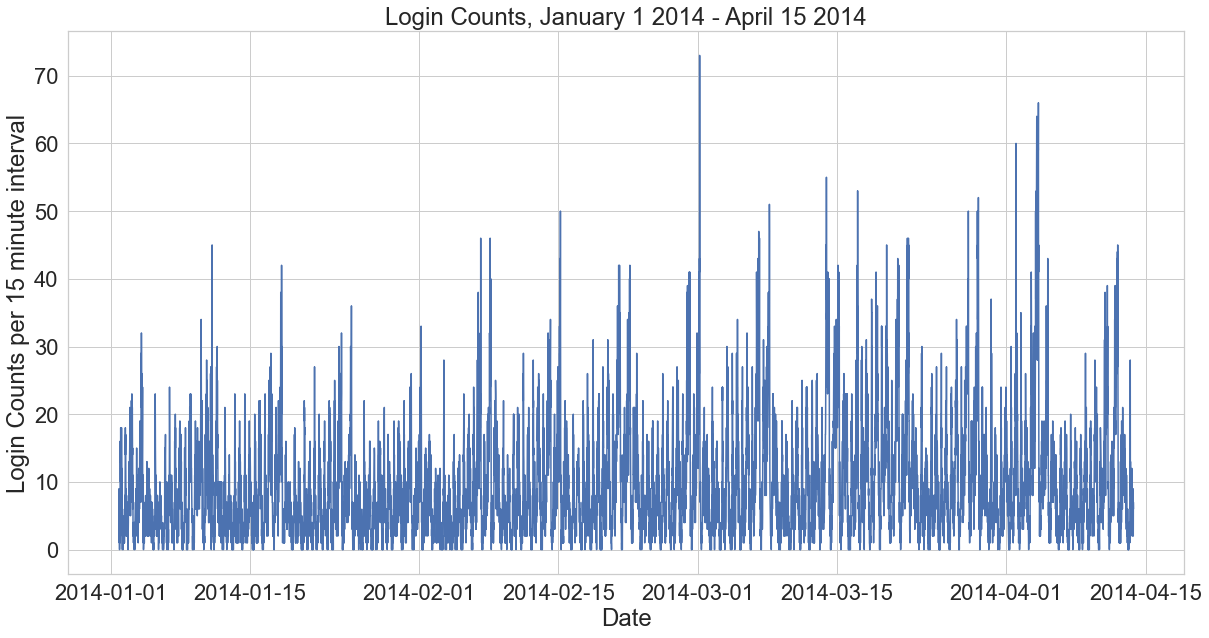

In [12]:
plt.figure(figsize=(20,10))
plt.plot(df1['count'])
plt.xlabel('Date')
plt.ylabel('Login Counts per 15 minute interval')
plt.title('Login Counts, January 1 2014 - April 15 2014')
plt.show();

From the above plot, we can see evidence of of daily and weekly patterns. Demand appears to peak on March 1st. 

The 15 minute increments are too granular to see larger trends, so I will now the explore the data by daily, monthly, and hourly counts.

#### ii. Aggregate Login Counts: Weekly Counts

In [13]:
df2 = df1.resample('D').sum()
df2.head()

,count
login_time,
2014-01-01,112
2014-01-02,681
2014-01-03,793
2014-01-04,788
2014-01-05,459


In [14]:
#Create Month Column
df2['month']= [calendar.month_name[i] for i in df2.index.month]
df2.head()

,count,month
login_time,,
2014-01-01,112,January
2014-01-02,681,January
2014-01-03,793,January
2014-01-04,788,January
2014-01-05,459,January


In [15]:
#Create Day Column
df2['day'] = [calendar.day_name[i] for i in df2.index.weekday]
df2.head()

,count,month,day
login_time,,,
2014-01-01,112,January,Wednesday
2014-01-02,681,January,Thursday
2014-01-03,793,January,Friday
2014-01-04,788,January,Saturday
2014-01-05,459,January,Sunday


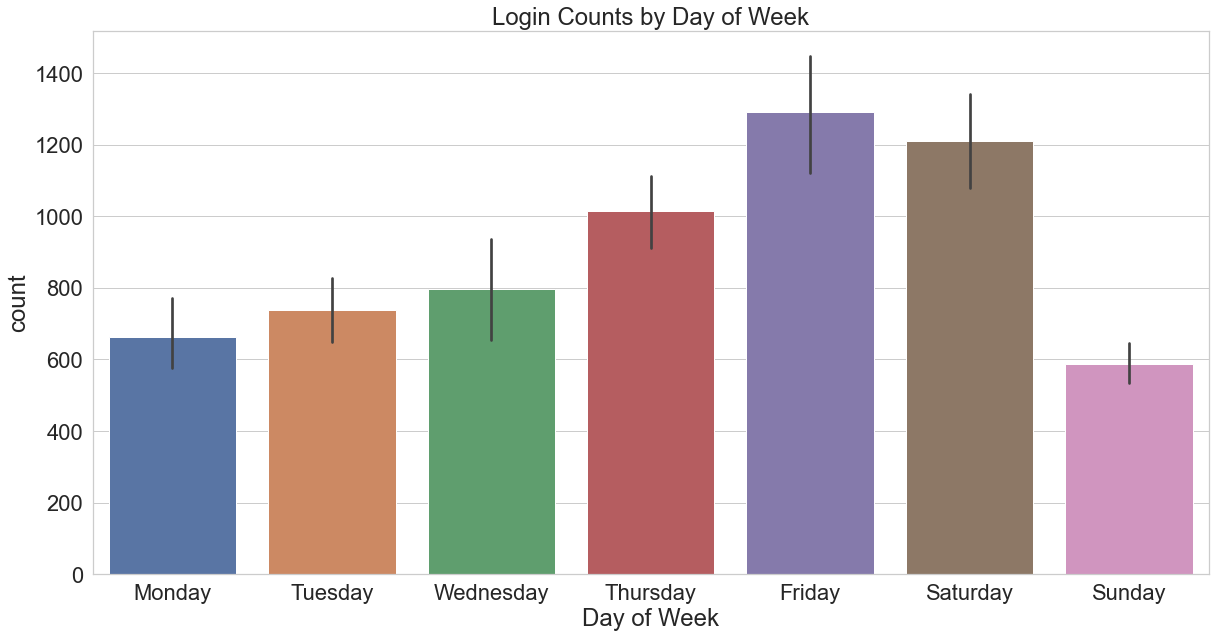

In [16]:
plt.figure(figsize=(20,10))

order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.barplot(x='day', y='count', data=df2, order=order)
plt.xlabel('Day of Week')
plt.title('Login Counts by Day of Week')
plt.show()

We can see that demand is at its lowest on Sunday, and grows from Monday to its peak on Friday and Saturday.

#### ii. Aggregate Login Counts: Monthly Counts

In [17]:
df3 = df1.resample('M').sum()
df3['month']= [calendar.month_name[i] for i in df3.index.month]
df3.head()

,count,month
login_time,,
2014-01-31,21239,January
2014-02-28,24673,February
2014-03-31,33723,March
2014-04-30,13507,April


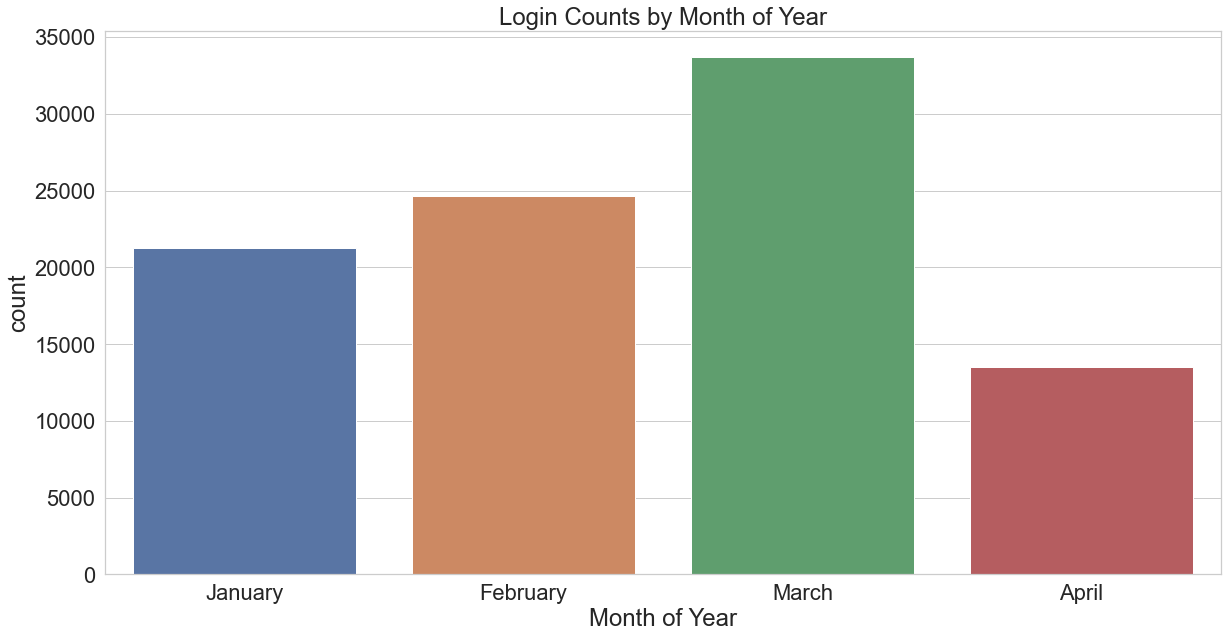

In [18]:
plt.figure(figsize=(20,10))

order = ["January", "February", "March", "April"]
sns.barplot(x='month', y='count', data=df3, order=order)
plt.xlabel('Month of Year')
plt.title('Login Counts by Month of Year')
plt.show()

Demand has grown from January to March. April is lower, but this is expected to some degree given that the final date in the data set is April 13, so only half of the monthly data is represented.

#### ii. Aggregate Login Counts: Hourly Counts

In [19]:
df4 = df1.resample('H').sum()
df4.head()

,count
login_time,
2014-01-01 20:00:00,24
2014-01-01 21:00:00,9
2014-01-01 22:00:00,21
2014-01-01 23:00:00,58
2014-01-02 00:00:00,53


In [20]:
df4 = df4.groupby(df4.index.hour).mean()
df4.head()

,count
login_time,
0,58.754902
1,61.931373
2,56.862745
3,47.362745
4,49.352941


In [21]:
df4['hour_of_day'] = df4.index
df4.head()

,count,hour_of_day
login_time,,
0,58.754902,0
1,61.931373,1
2,56.862745,2
3,47.362745,3
4,49.352941,4


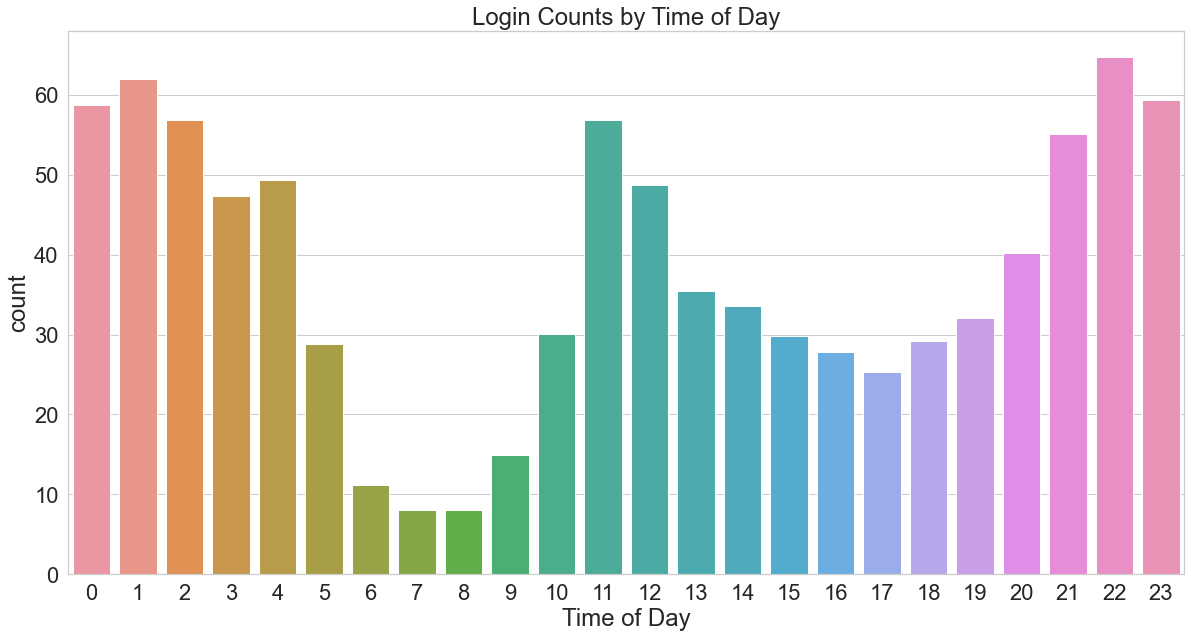

In [22]:
plt.figure(figsize=(20,10))

sns.barplot(x='hour_of_day', y='count', data=df4)
plt.xlabel('Time of Day')
plt.title('Login Counts by Time of Day')
plt.show()

As we see above, on average, demand peaks beginning at 11:00pm until 1:00 am, then declines sharply at 4:00 am. Demand picks up again around lunch time, drops over the afternoon, then begins to pick up again around 6:00 pm

## Part Two: Experiment and metrics design

> The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.



#### 1. Key Metrics

As the goal is increased driver availability by having drivers serve both cities, I propose that average customer wait time is an ideal metric. By analysing wait time with and without the toll reimbursement offer, we can will be able to assess if reimbursing toll costs leads to increased driver availability.

#### 2. Experimental Design

Null Hypothesis: Reimbursing toll costs does not change customer wait time in Gotham and Metropolis.
    
Alternative Hypothesis: Reimbursing toll costs decreases customer wait time in Gotham and Metropolis.

The experiment should be conducted over two, two-week periods, running Monday to Sunday. The time periods should be within the same month to avoid seasonal shifts, and events such as holidays and major sporting/entertainment events should be avoided.

<b>A. Data Collection</b>
In the two-week control period, customer wait times are collected in both Gotham and Metropolis. Tolls are not reimbursed in this period, though the drivers should be made aware of the upcoming pilot project where tolls will be reimbursed. Alternatively, if Ultimate already has this data, they can proceed directly to the expirmental period.

In the two-week experimental period, tolls are reimbursed and drivers are encouraged to drive in both cities. Customer wait times are collected.

<b>B. Analysis </b>

Mean times and standard deviation should be calculated for the control period, and mean time for the experimental period. A two-tailed Z test can be conducted with p = 0.05. If Z falls inside the rejection region, we can reject the null hypothesis.

<b>C. Caveats:</b>
<ul>
    <li>Ultimate must ensure that drivers are made aware of the new program, and the method and schedule by which they will be reimbursed.</li><br>
        <li>Two weeks may not be long enough to see the effects of the program, as it may take drivers more time to adjust their driving habits.</li><br>
    <li>Even with the toll reimbursement, there may be other reasons why drivers want to stay in their home city, such as familiarity with the area, decreased fuel expenses, and the desire to be able to return home quickly after their final customer drop-off.</li>
    <li>It is important to consider the possibility that encouraging drivers to cross into other cities may actually increase wait time, as drivers are spending more time travelling from one city to another.</li>


## Part Three: Predictive Modelling

> Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

### 1. Cleaning & Exploratory Data Analysis 

### i. Import user cohort JSON

In [23]:
#Import JSON
dfr = pd.read_json('ultimate_data_challenge.json')

#Visual check
dfr.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [24]:
dfr.shape

(50000, 12)

In [25]:
dfr.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [26]:
dfr.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [27]:
dfr.signup_date.min()

'2014-01-01'

In [28]:
dfr.last_trip_date.max()

'2014-07-01'

#### There are null values in the data set, including:
<ul>
<li>avg_rating_of_driver: 8122</li>
<li>phone: 396</li>
<li>avg_rating_by_drive: 201</li>
</ul>

The data ranges from January 1, 2014 to July 1, 2014.

### ii. Clean Data 

##### a. Average Rating of Driver

In [29]:
#Replace avg_rating_of_driver null values
dfr['avg_rating_of_driver'].describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [30]:
dfr['avg_rating_of_driver'].median()

4.9

My assumption is that drivers with no rating have only recently began working for Ultimate, and thus haven't been rated yet. I will replace these null values with the mean.

In [31]:
#Replace with Mean
dfr['avg_rating_of_driver'] = dfr['avg_rating_of_driver'].fillna(dfr['avg_rating_of_driver'].mean())

##### b. Phone

In [32]:
dfr['phone'].value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [33]:
dfr['phone'].nunique()

2

In [34]:
percent_missing = dfr['phone'].isnull().sum() * 100 / len(dfr)
percent_missing

0.792

As less than 1% of the columns are missing phone data, I will drop these columns.

In [35]:
dfr = dfr[dfr['phone'].notna()]

##### c. avg_rating_by_driver

In [36]:
dfr['avg_rating_by_driver'].describe()

count    49406.000000
mean         4.777861
std          0.447114
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [37]:
percent_missing = dfr['avg_rating_by_driver'].isnull().sum() * 100 / len(dfr)
percent_missing

0.3991613579550036

Again, as less than .5% of the columns are missing avg_rating_by_driver data, I will drop these columns.

In [38]:
dfr = dfr[dfr['avg_rating_by_driver'].notna()]

In [39]:
dfr.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

### iii. Exploratory Data Analysis 

As the last date in the data set was July 1, 2014, I will define active users as:
    <b> Users who took a trip between June 1, 2014 and July 1, 2014</b>
    
Before I begin exploratory analysis, I will create an 'Active' feature to identify these users.

#### A. 'Active User' Feature

In [40]:
dfr['last_trip_date'] = pd.to_datetime(dfr['last_trip_date'])

In [41]:
dfr.dtypes

city                              object
trips_in_first_30_days             int64
signup_date                       object
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [42]:
active_user_date = "2014-6-1"

dfr['active_user'] = np.where(dfr["last_trip_date"] >= active_user_date, True, False)
dfr.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


#### A. User Analysis: City

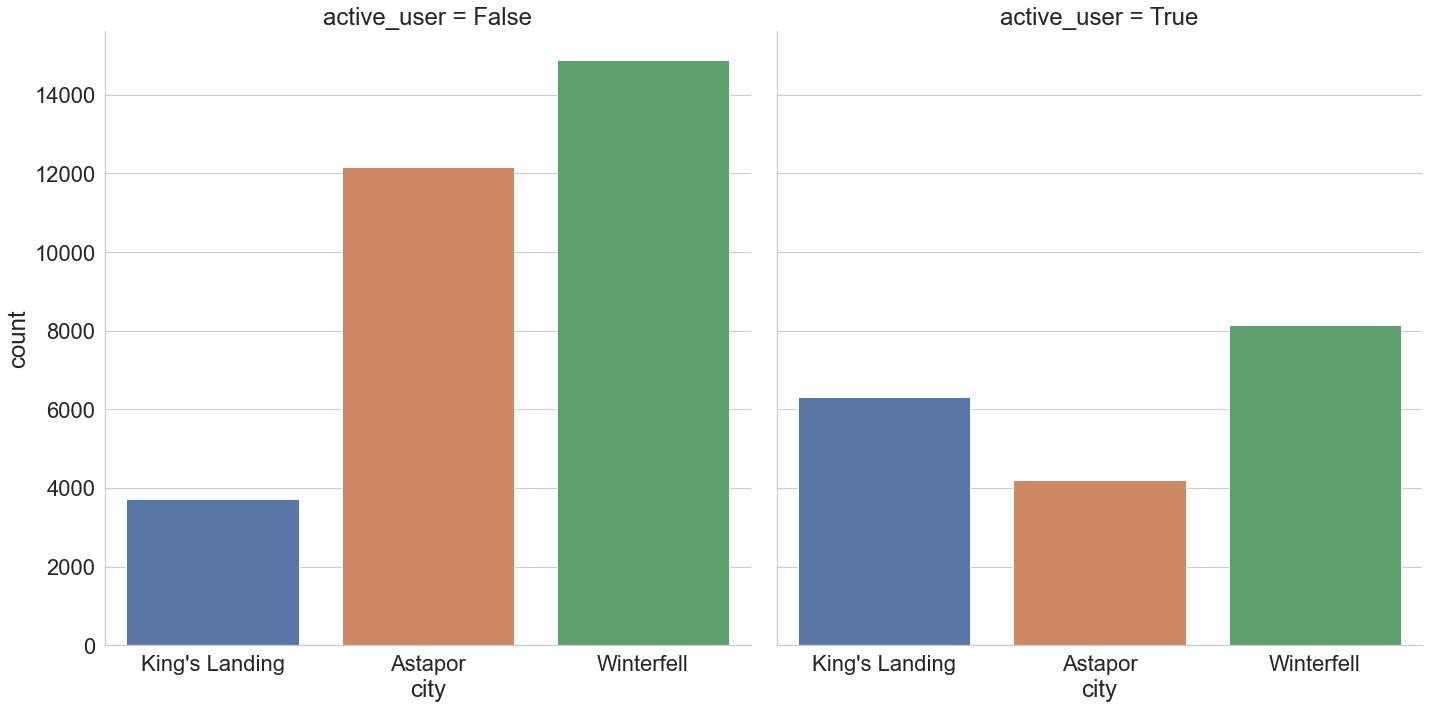

In [43]:
#Compare Year of Sign-Up
g = sns.catplot(x="city", col="active_user", data=dfr, kind="count", height=10)

This is interesting: Based on sign-ups, King's Landing users are much more likely to become active than Astopor or Winterfell users.

#### B. Trips in First 30 Days

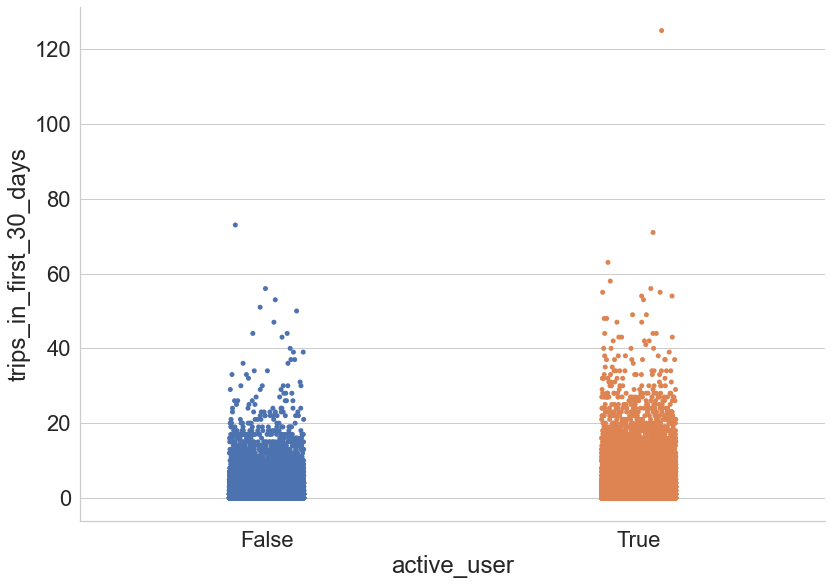

In [44]:
sns.catplot(x="active_user", y="trips_in_first_30_days", height=8.27, aspect=11.7/8.27, data=dfr)
plt.show();

Active users appear to take slightly more rides in the first 30 days, with one user taking over 120!

#### C. Average Rating by Driver

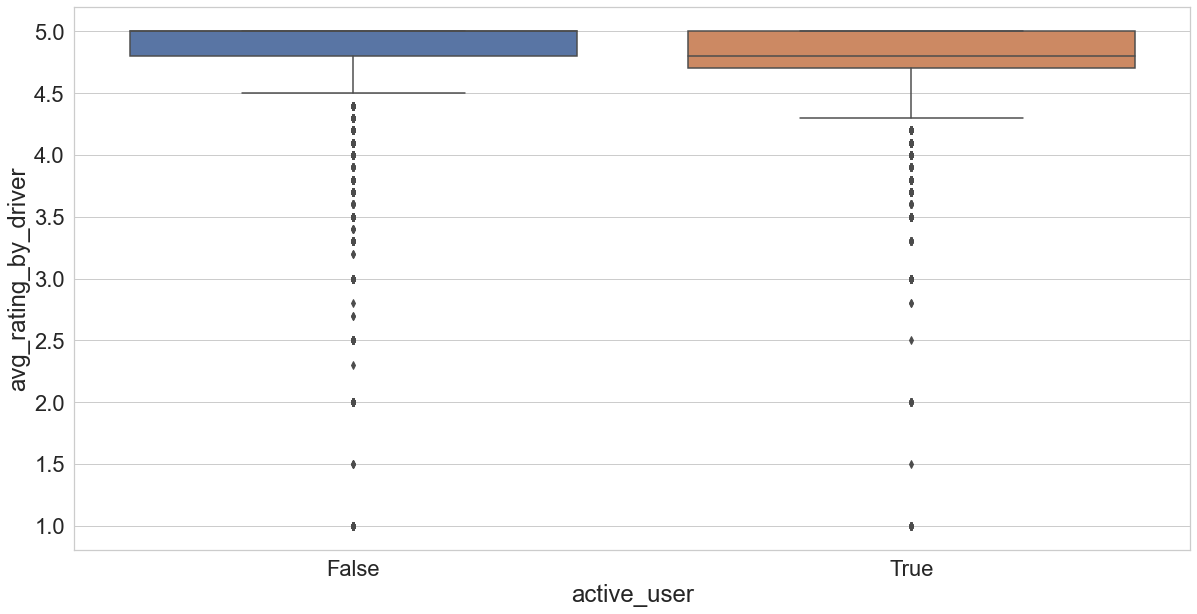

In [45]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="active_user", y="avg_rating_by_driver", data=dfr)

#### D. Average Surge

<i> The average surge multiplier over all of this user’s trips</i>


<Figure size 1440x720 with 0 Axes>

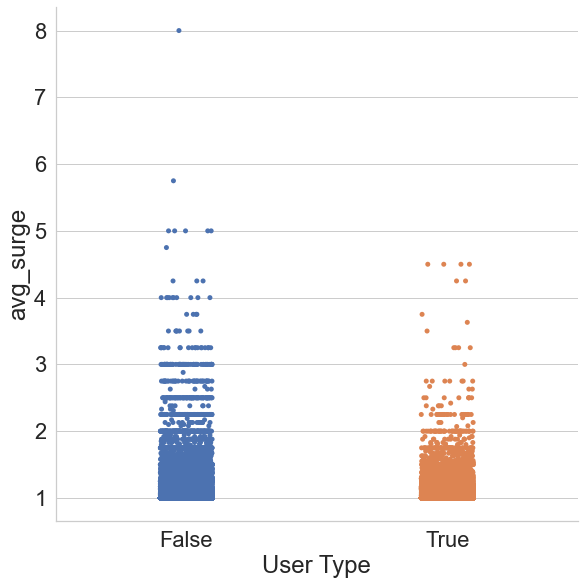

In [46]:
#Cat Plot of Average Surge Multiplier
plt.figure(figsize=(20,10))

sns.catplot(x="active_user", y="avg_surge", data=dfr, height=8.27)
plt.xlabel('User Type')

plt.show();

There appears to be a few outliers among non-active users with very high average surge multipliers.

#### E. Phone Model

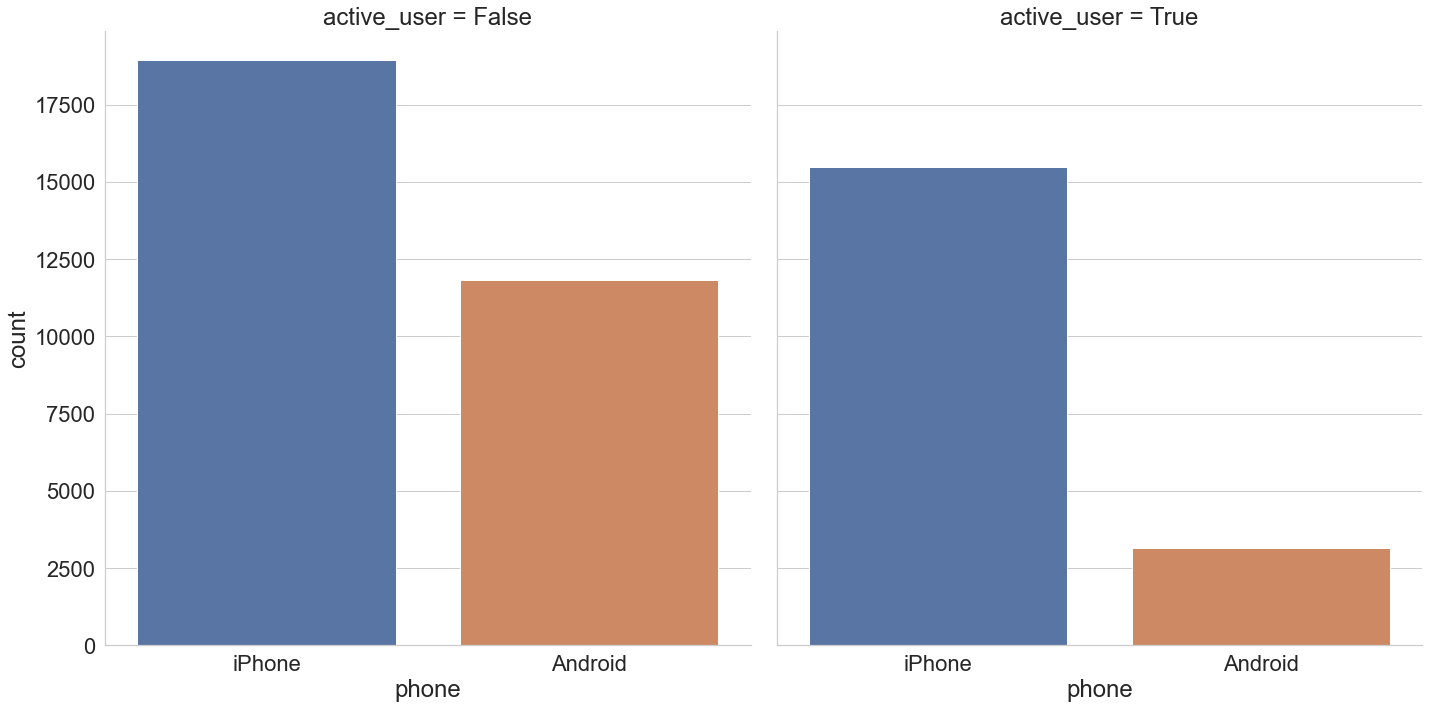

In [47]:
#Compare Phone Model
g = sns.catplot(x="phone", col="active_user", data=dfr, kind="count", height=10)

It appears that a higher proportion of iPhone users are becoming active users, compared to android.

#### F. Ultimate Black

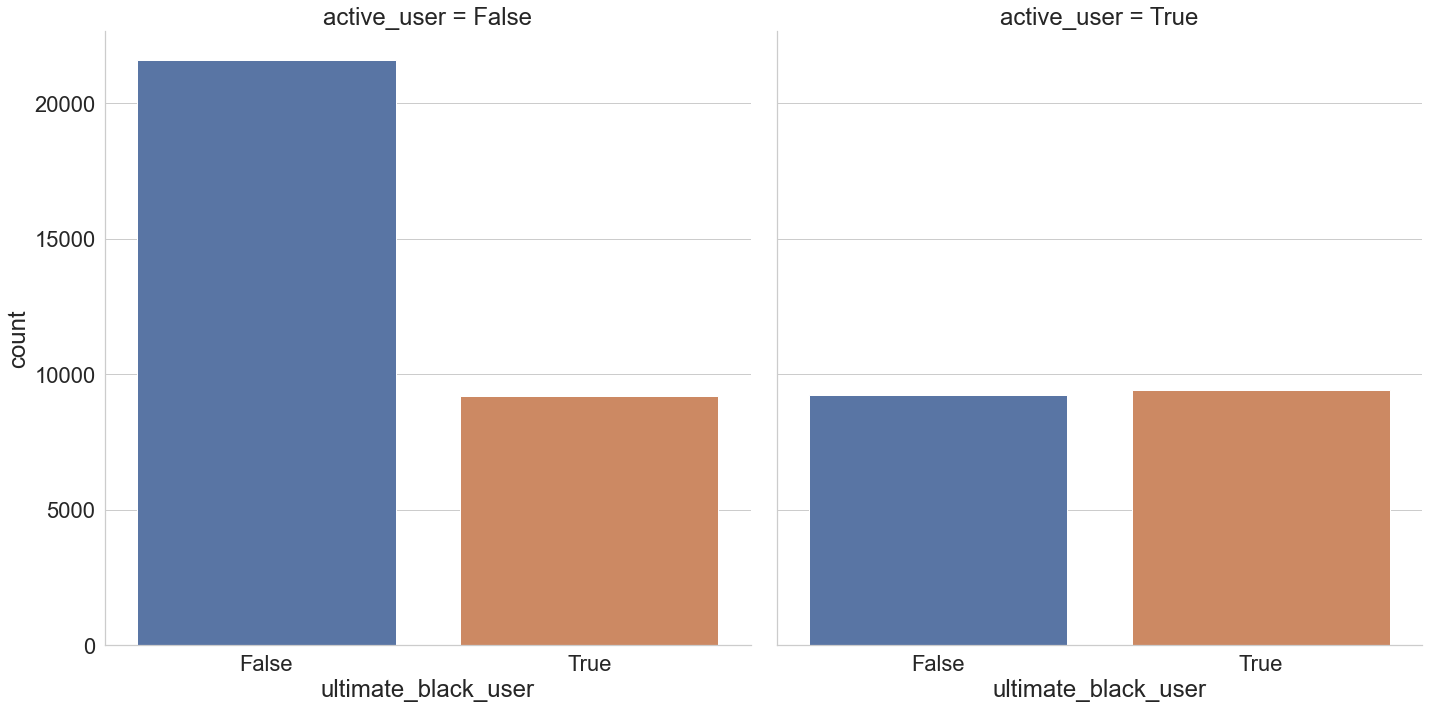

In [48]:
#Compare Ultimate Black versus Non Ultimate Black Users
g = sns.catplot(x="ultimate_black_user", col="active_user", data=dfr, kind="count", height=10)

Among active users, there appears to be an even split between those who have used Ultimate Black and those who have not, while only a third of non-active users have used Ultimate Black.

Active users have a slightly wider distribution of ratings by drivers, which may be attributed to more time spent using the platform.

#### G. Weekday Percentage

<i>The percent of the user’s trips occurring during a weekday.</i>

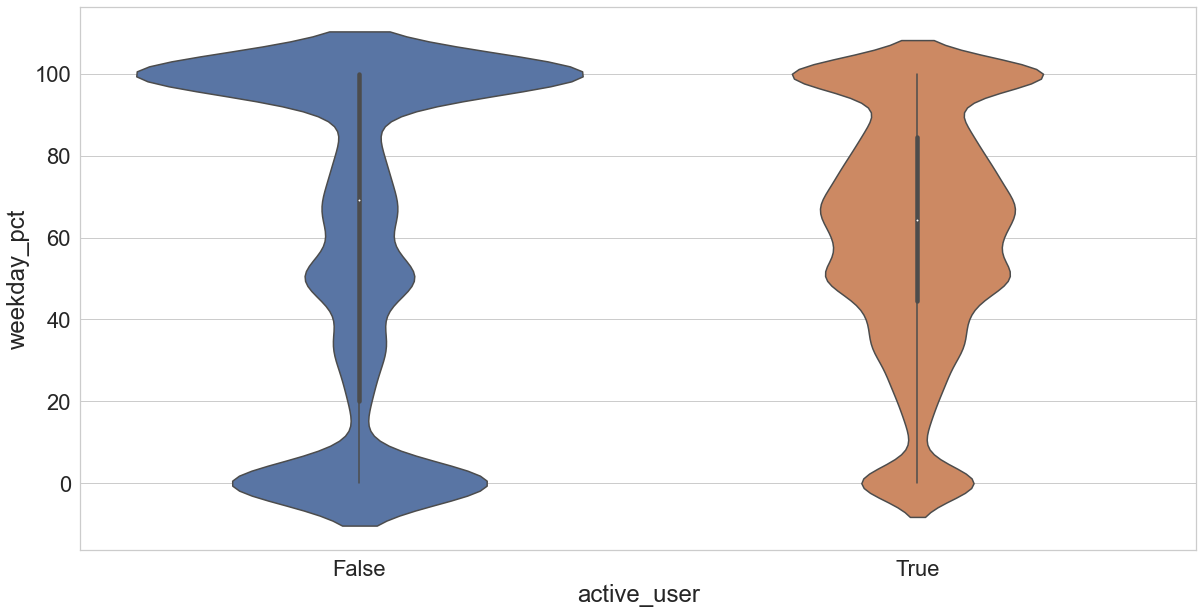

In [49]:
plt.figure(figsize=(20,10))

ax = sns.violinplot(x="active_user", y="weekday_pct", data=dfr)

Non-active users are more polarized, with many only taking rides on weekday, or on weekends, but not both.

The active user group also contains riders like this, but many appear to take rides on both weekdays and weeekends.

#### H.  Average Distance

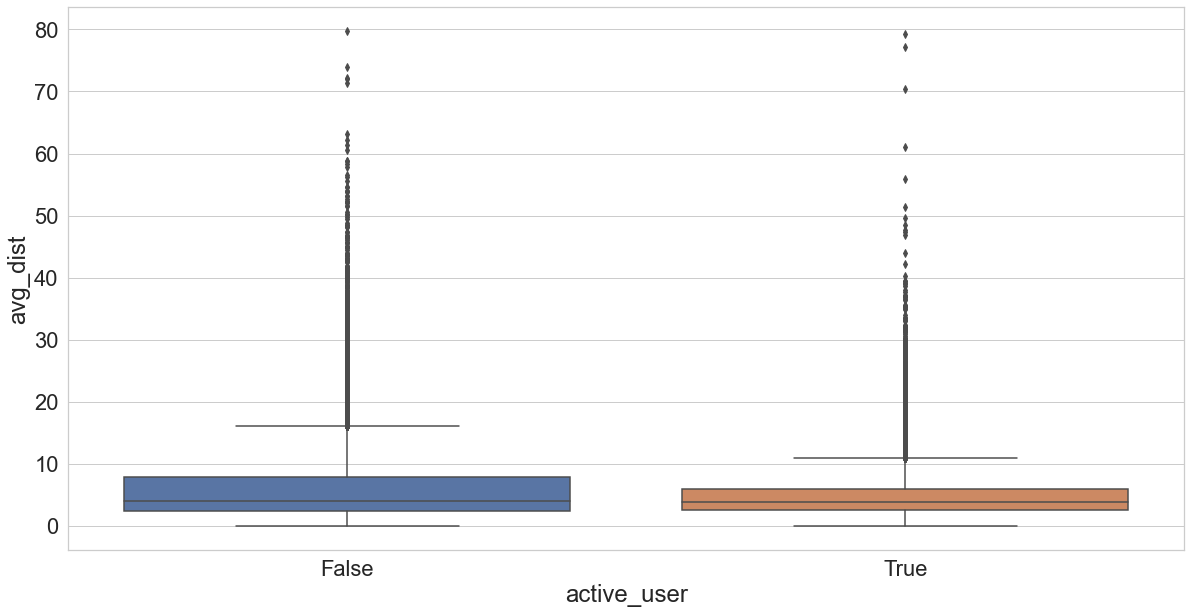

In [50]:
#Box Plot of Average Distance
plt.figure(figsize=(20,10))

ax = sns.boxplot(x="active_user", y="avg_dist", data=dfr)
plt.show();

While the median appears to be similar, non-active users have a slightly larger range of average distances.

#### E. Average Rating of Driver

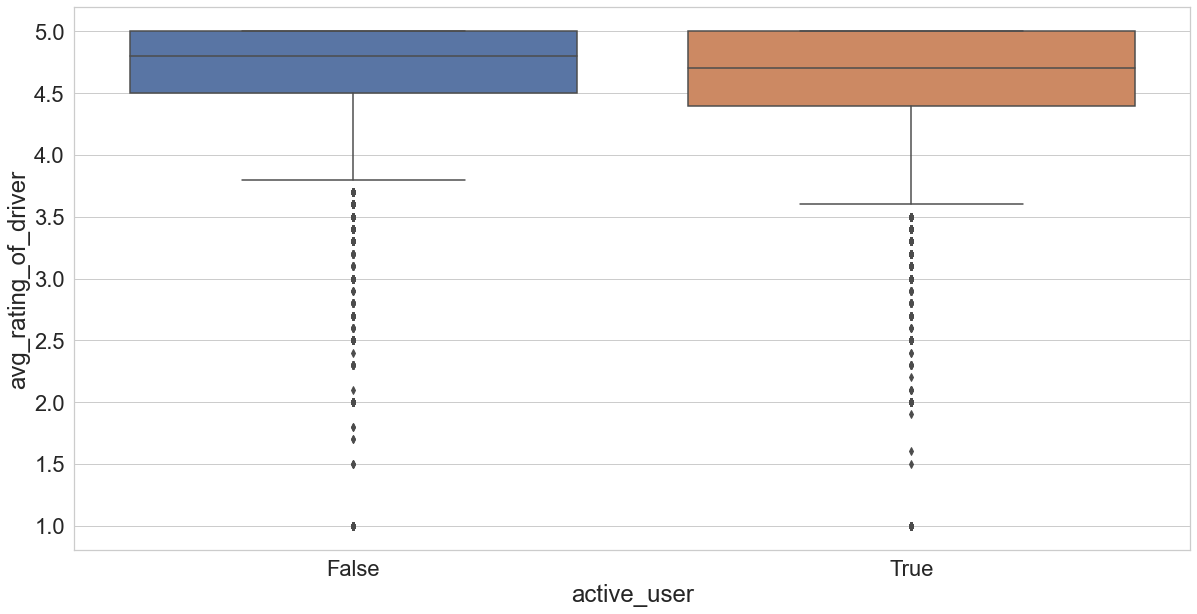

In [51]:
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="active_user", y="avg_rating_of_driver", data=dfr)

This trend is similar to the one above, with active users rating their drivers slightly lower than non-active users.

### 2. Predictive Model

In [52]:
dfr.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


### i. Pre-Processing

<i>Create Dummy Variables for categorical features.</i>

In [53]:
#Create Dummies for City
classCity = pd.get_dummies(dfr.city)

#Create Dummies for Phone
classPhone = pd.get_dummies(dfr.phone)

#Create Dummies for Phone
classBlack = pd.get_dummies(dfr.ultimate_black_user, prefix='ultimate_black_')

#Create Dummies for Active user
classActive = pd.get_dummies(dfr.active_user, prefix='active_user_')

In [54]:
#Join Dummies
dfm = pd.concat([dfr, classCity, classPhone, classBlack, classActive], axis=1)

#Visual Check
dfm.head(2)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,...,active_user,Astapor,King's Landing,Winterfell,Android,iPhone,ultimate_black__False,ultimate_black__True,active_user__False,active_user__True
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,...,True,0,1,0,0,1,0,1,0,1
1,Astapor,0,2014-01-29,5.0,1.0,2014-05-05,Android,0.0,False,50.0,...,False,1,0,0,1,0,1,0,1,0


In [55]:
#Drop Categorical Features
dfm = dfm.drop(['city', 'signup_date', 'last_trip_date', 'phone', 'ultimate_black_user', 'active_user', 'active_user__False'], axis=1)

#Visual Check
dfm.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell,Android,iPhone,ultimate_black__False,ultimate_black__True,active_user__True
0,4,4.7,1.10,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1,1
1,0,5.0,1.00,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0,0
2,3,4.3,1.00,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0,0
3,9,4.6,1.14,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1,1
4,14,4.4,1.19,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0,0


In [56]:
dfm.shape

(49406, 15)

#### ii. Train/Test Split

In [57]:
y = dfm['active_user__True']
X = dfm.drop(['active_user__True'], axis = 1) 

In [58]:
#Split Features into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#### iii. Scale

In [59]:
#Instantiate MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

#Fit and Transform X_train
mm_scaler.fit_transform(X_train)

#Transform X_test
mm_scaler.transform(X_test)

array([[0.032     , 0.7       , 0.00571429, ..., 1.        , 0.        ,
        1.        ],
       [0.024     , 0.95      , 0.03571429, ..., 1.        , 0.        ,
        1.        ],
       [0.016     , 1.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.056     , 1.        , 0.04142857, ..., 0.        , 0.        ,
        1.        ],
       [0.008     , 0.75      , 0.        , ..., 1.        , 1.        ,
        0.        ]])

#### iv. Model

In [60]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=14, max_depth = 10, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.823
Accuracy score (validation): 0.776

Learning rate:  0.1
Accuracy score (training): 0.849
Accuracy score (validation): 0.782

Learning rate:  0.25
Accuracy score (training): 0.890
Accuracy score (validation): 0.780

Learning rate:  0.5
Accuracy score (training): 0.925
Accuracy score (validation): 0.763

Learning rate:  0.75
Accuracy score (training): 0.929
Accuracy score (validation): 0.756

Learning rate:  1
Accuracy score (training): 0.935
Accuracy score (validation): 0.736



In [61]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate = .1, max_features=14, max_depth = 5, random_state = 0, min_samples_split=50)
gb.fit(X_train, y_train)
print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
print()

Accuracy score (training): 0.801
Accuracy score (validation): 0.794



In [70]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_train)

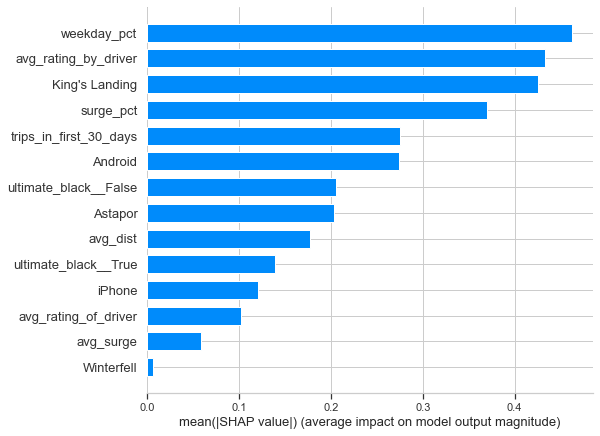

In [71]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

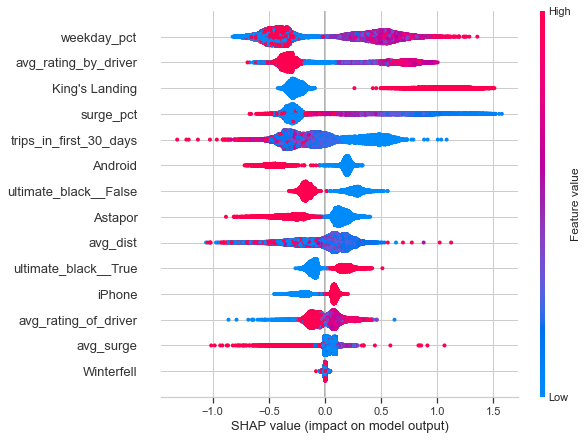

In [72]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)